## Building CNN The Right Way

This assignment focusses on use concepts in the right way to build a good Convolutional Neural Network

### Import necessary modules

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


#### Visualzing dataset

* Its very important to visualize that dataset to understand the complexity of features the network should learn
* It also helps in understanding what sort of image augmentation should be applied to the datasets

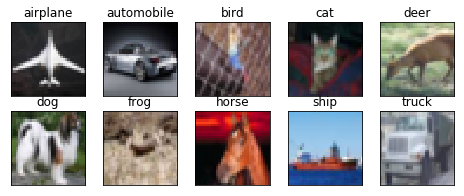

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

#### Helper functions

* Following are helper functions to understand how network performed
* It plots graph on model accuracy and loss for training vs validation dataset over increasing epochs

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

#### Pixel Normalization

* It is good to rescale dataset, so that network sees image in same range and hence makes it easy to learn

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#### Not-So-Ideal Network

* Following is network is not an ideal architecture
* Some issues:
  * Dropout in last layer
  * Dense layers
  * Increasing channels
  * Dropout value is high (0.25)
  * No Batch Normalization
* Some ways to fix it:
  * No Dropout in last layer
  * Remove Dense layers
  * Have network with alternating high channels & low channels (squeeze & excite)
  * Add Batch Normalization
  * Add Image Normalization
  * Add Image Augmentation
  

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3))) # Output: 32x32x48, RF: 3
model.add(Activation('relu')) 
model.add(Convolution2D(48, 3, 3)) # Output: 30x30x48, RF: 5
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Output: 15x15x48, RF: 10
model.add(Dropout(0.25))
model.add(Convolution2D(96, 3, 3, border_mode='same')) # Output: 15x15x96, RF: 12
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3)) # Output: 13x13x96, RF: 14
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Output: 6x6x96, RF: 28
model.add(Dropout(0.25))
model.add(Convolution2D(192, 3, 3, border_mode='same')) # Output: 6x6x192, RF: 30
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3)) # Output: 4x4x192, RF: 32
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Output: 2x2x192, RF: 64
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 96)        41568     
__________

#### Run the network and examine output

* Base accuracy = 84.05 (87th Epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 24s 61ms/step - loss: 1.8493 - acc: 0.2934 - val_loss: 1.5250 - val_acc: 0.4335
Epoch 2/100
390/390 [==============================] - 22s 56ms/step - loss: 1.3320 - acc: 0.5197 - val_loss: 1.1241 - val_acc: 0.5975
Epoch 3/100
390/390 [==============================] - 22s 56ms/step - loss: 1.1064 - acc: 0.6112 - val_loss: 0.9468 - val_acc: 0.6651
Epoch 4/100
390/390 [==============================] - 22s 56ms/step - loss: 0.9730 - acc: 0.6601 - val_loss: 0.8628 - val_acc: 0.6932
Epoch 5/100
390/390 [==============================] - 22s 56ms/step - loss: 0.8692 - acc: 0.6979 - val_loss: 0.7596 - val_acc: 0.7394
Epoch 6/100
390/390 [==============================] - 22s 56ms/step - loss: 0.7948 - acc: 0.7268 - val_loss: 0.7441 - val_acc: 0.7461
Epoch 7/100
390/390 [==============================] - 22s 56ms/step - loss: 0.7396 - acc: 0.7465 - val_loss: 0.6976 - val_acc: 0.7577
Epoch 8/100
390/390 [==============================] - 

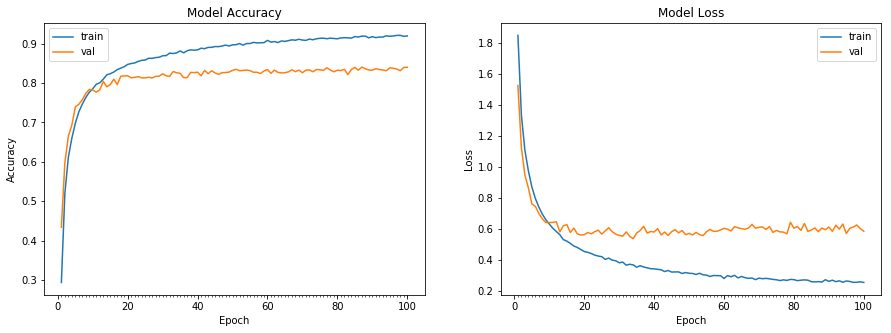

Accuracy on test data is: 84.01


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### Improving the network architecure

We improve the network by making the following changes:
  * No Dropout in last layer
  * Remove Dense layers
  * Have network with alternating high channels & low channels (squeeze & excite)
  * Add Batch Normalization
  * Add Image Normalization
  * Add Image Augmentation

In [0]:
# Define the model

dropout_val = 0.1
conv_start_size = 64

def Conv_Block(model, num_channels):
  model.add(Convolution2D(num_channels, 3, 3, border_mode='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu')) 
  model.add(Dropout(dropout_val))
  model.add(Convolution2D(2*num_channels, 3, 3, border_mode='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout_val))
  
def Transition_Block(model, num_channels):
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(num_channels, 1, 1))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(dropout_val))


model = Sequential()
model.add(Convolution2D(conv_start_size, 3, 3, border_mode='same', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(lambda_val))) # Output: 32x32x64
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(dropout_val))

Conv_Block(model, conv_start_size) # 32x32x128
Transition_Block(model, conv_start_size) # 16x16x64

Conv_Block(model, conv_start_size) # 16x16x128
Transition_Block(model, conv_start_size) # 8x8x64

Conv_Block(model, conv_start_size) # 8x8x128
Transition_Block(model, conv_start_size) # 4x4x64

Conv_Block(model, conv_start_size) # 4x4x128
Transition_Block(model, conv_start_size) # 2x2x64


model.add(Convolution2D(10, 2, 2)) # Output: 1x1x10

model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (2, 2))`


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_27 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 64)        0         
__________

#### Run the improved network and examine output

* Gives accuracy of 88.4, better than 84.05

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 37s 95ms/step - loss: 1.6908 - acc: 0.3953 - val_loss: 2.1101 - val_acc: 0.3066

Epoch 00001: val_acc improved from -inf to 0.30660, saving model to best_weights.hdf5
Epoch 2/100
390/390 [==============================] - 33s 84ms/step - loss: 1.2646 - acc: 0.5570 - val_loss: 2.0261 - val_acc: 0.3450

Epoch 00002: val_acc improved from 0.30660 to 0.34500, saving model to best_weights.hdf5
Epoch 3/100
390/390 [==============================] - 33s 85ms/step - loss: 1.0225 - acc: 0.6487 - val_loss: 1.1599 - val_acc: 0.6079

Epoch 00003: val_acc improved from 0.34500 to 0.60790, saving model to best_weights.hdf5
Epoch 4/100
390/390 [==============================] - 33s 84ms/step - loss: 0.8796 - acc: 0.6990 - val_loss: 1.0201 - val_acc: 0.6508

Epoch 00004: val_acc improved from 0.60790 to 0.65080, saving model to best_weights.hdf5
Epoch 5/100
390/390 [==============================] - 33s 85ms/step - loss: 0.7899 - acc: 0.7312 - val_loss: 0.910

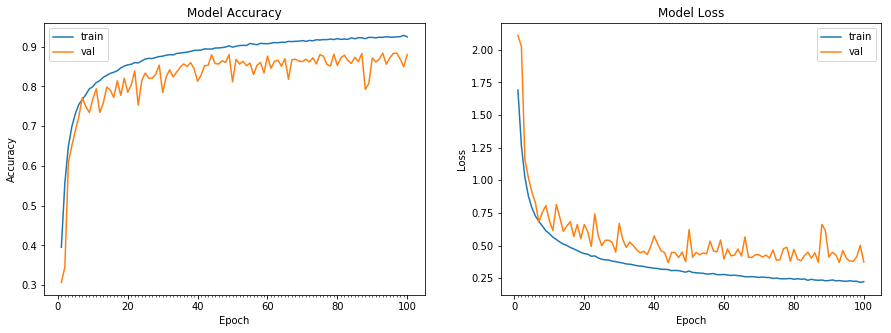

Accuracy on test data is: 88.04


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

checkpoint = ModelCheckpoint("best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))